# OVERVIEW AND BACKGROUND

Understanding group decision-making in mobile species is a complex challenge. The integration of both GPS and acoustic sensors into tags deployed on multiple individuals in groups can help us systematically quantify communication between individuals as well as their movement responses - based on who is calling, the context of the call, and how the group reacts. However, the resulting datasets are very large, and the manual identification and classification of calls is both time and labor consuming. 

<img src="https://raw.githubusercontent.com/KiranLDA/CCAS_ML/master/images/ML_code_overview.png">

This code interfaces with a supervised machine learning tool for detecting call presence and/or call type in field recordings. We train a convolutional neural network to extract features from spectrograms. Bidirectional gated recurrent units learned temporal structure from these features, and a final feed-forward network predicted call type. We also used data augmentation to increase the number of training examples for underrepresented call types. We illustrate the method on bio-logging data from meerkat groups, where all individuals in the group were equipped with acoustic loggers. 

# START CODING

The parameter {is_forked} below is used to determine whether or not the model produces only a calltype classification (when False) or a calltype and a call presence classification (when True).


In [1]:
is_forked = True

## IMPORT LIBRARIES

In [48]:
github_dir = "/home/kiran/Documents/github/CCAS_ML"

# add path to local functions
import os
os.chdir(github_dir)

# import all the params for this model
from example_params import *

# import own functions
import preprocess.preprocess_functions as pre
import postprocess.evaluation_metrics_functions as metrics
import postprocess.merge_predictions_functions as ppm
import model.specgen_batch_generator as bg
import model.network_class as rnn
# import postprocess.visualise_prediction_functions as pp
from model.callback_functions import LossHistory

# import normal packages used in pre-processing
import numpy as np
import librosa
import warnings
import ntpath
import os
from itertools import compress  
from random import random, shuffle
from math import floor
import statistics
import glob

# plotting
import matplotlib.pyplot as plt

# ML section packages
import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Input, Flatten
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, SeparableConv2D, concatenate
from keras.layers import Reshape, Permute
from keras.layers import TimeDistributed, Dense, Dropout, BatchNormalization
from keras.models import load_model
from keras.layers import GRU, Bidirectional, GlobalAveragePooling2D
from keras.callbacks import TensorBoard

# postprocessfrom decimal import Decimal
from decimal import Decimal
import pandas as pd
import pickle

# evaluate and plot 
import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import csv

----------------------------------------------------------------------
# PREPROCESSING / DATA WRANGLING

Currently, all the meerkat files are found on the server. The labels in particular are divided by year (currently 2017 and 2019) and all file labels are in a single document. This bit of code just takes these and puts them together

In [3]:
# Compile all the synched label files together
labels_all = pd.DataFrame()
for directory in label_dirs:
    for group in group_IDs:
        temp = pd.read_csv(os.path.join(directory, group +"_ALL_CALLS_SYNCHED.csv"), sep=sep,
                       header=0, engine = engine, encoding = encoding) 
        temp["group"] = group
        labels_all = pd.concat([labels_all, temp]) 
        del temp

labels_all = labels_all[-labels_all.wavFileName.str.contains('SOUNDFOC')]
labels_all = labels_all.reset_index(drop = True)

## Look at summary data to understand meerkats

In [4]:
labels_all.groupby(['ind','group']).size().reset_index().rename(columns={0:'count'})

,ind,group,count
0,VCVM001,HM2017,1518
1,VHMF001,HM2017,3296
2,VHMF001,HM2019,5735
3,VHMF015,HM2019,5841
4,VHMF019,HM2019,2404
5,VHMF022,HM2019,2373
6,VHMF029,HM2019,749
7,VHMF030,HM2019,9744
8,VHMM002,HM2017,2426
9,VHMM003,HM2017,333


In [5]:
labels_all.groupby(['ind','group', 'date']).size().reset_index().rename(columns={0:'count'})

,ind,group,date,count
0,VCVM001,HM2017,20170806,194
1,VCVM001,HM2017,20170823,219
2,VCVM001,HM2017,20170824,207
3,VCVM001,HM2017,20170825,224
4,VCVM001,HM2017,20170903,376
...,...,...,...,...
162,VLM248,L2019,20190805,385
163,VLM248,L2019,20190806,426
164,VLM248,L2019,20190807,1129
165,VLM248,L2019,20190808,287


In [6]:
labels_all.groupby(['ind', 'date']).size().reset_index().rename(columns={0:'count'})

,ind,date,count
0,VCVM001,20170806,194
1,VCVM001,20170823,219
2,VCVM001,20170824,207
3,VCVM001,20170825,224
4,VCVM001,20170903,376
...,...,...,...
162,VLM248,20190805,385
163,VLM248,20190806,426
164,VLM248,20190807,1129
165,VLM248,20190808,287


Data also contain focal follows (someone walking around behind the meerkats) and the resultion of this data is different and therefore not anlysed with the collar data

In [7]:
# subset all the audio files that we should use in the analysis (i.e. not focal follow data)
audio_files = list(set(labels_all["wavFileName"]))
audio_filenames = list(compress(audio_files, ["SOUNDFOC" not in filei for filei in audio_files]))

# subset all the audio files that we should use in the analysis (i.e. not focal follow data)
label_files = list(set(labels_all["csvFileName"]))
label_filenames = list(compress(label_files, ["SOUNDFOC" not in filei for filei in label_files]))

# get the file IDS without all the extentions (used later for naming)
all_filenames = [audio_filenames[i].split(".")[0] for i in range(0,len(audio_filenames))]

Then we locate all the paths to the files

In [8]:
# find all the labels
EXT = "*.csv"
label_filepaths = []
for PATH in acoustic_data_path :
      label_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])
EXT = "*.CSV"
for PATH in acoustic_data_path :
      label_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])

# find all audio paths (will be longer than label path as not everything is labelled)
audio_filepaths = []
EXT = "*.wav"
for PATH in audio_dirs:
      audio_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])

### Create a label table

Currently, the labels are stored in a file generated by audition for the meerkats. We want to these manual labels and put them into a more meaningful categories for for the machine learning. To set categories, I use a pre-defined dictionary called call_types that is defined in the parameters file and which specifies what the different classes are for the call types. Anything strange gets put into a category "oth" for other.

In [9]:
# Create the label table
label_table = pre.create_meerkat_table(labels_all, call_types, sep,
                                       start_column, duration_column, columns_to_keep,
                                       label_column, convert_to_seconds, 
                                       label_for_other, label_for_noise, engine,
                                       multiclass_forbidden)

This label 'c' on line 5909 will be classed as 'oth'
This label 'c' on line 7266 will be classed as 'oth'
This label 'cn' on line 7921 will be classed as 'oth'
This label 'chew' on line 8385 will be classed as 'oth'
This label 'sb' on line 8504 will be classed as 'oth'
This label 'chew' on line 8782 will be classed as 'oth'
This label 'chew' on line 8862 will be classed as 'oth'
This label 'chew' on line 8886 will be classed as 'oth'
This label 'chew' on line 8887 will be classed as 'oth'
This label 'chew' on line 8890 will be classed as 'oth'
This label 'chew' on line 8914 will be classed as 'oth'
This label 'chew' on line 8933 will be classed as 'oth'
This label 'chew' on line 8962 will be classed as 'oth'
This label 'chew' on line 9008 will be classed as 'oth'
This label 'chew' on line 9011 will be classed as 'oth'
This label 'chew' on line 9045 will be classed as 'oth'
This label 'chew' on line 9046 will be classed as 'oth'
This label 'chew' on line 9243 will be classed as 'oth'
Th

In [10]:
# estimate the average beep length because many of them are not annotated in the data
avg_beep = round(statistics.mean(label_table.loc[label_table["beep"],"Duration"].loc[label_table.loc[label_table["beep"],"Duration"]>0]),3)
label_table.loc[(label_table["beep"].bool and label_table["Duration"] == 0.) ==True, "Duration"] = avg_beep
label_table.loc[(label_table["beep"].bool and label_table["Duration"] == avg_beep) ==True, "End"] += avg_beep
print(avg_beep)

0.068


In [11]:
label_table.isnull().any()


# label_table['wav_path'] = ''
#for idx,item in enumerate(label_table['wavFileName']):
    #print(row)
    #print(idx)
    #label_table.loc[idx, 'wav_path'] = [pathi for pathi in audio_filepaths if item in pathi][0]
    #label_table.loc[idx,'wavFileName']
#1981
label_table.loc[1981,]
#label_table['wav_path']
# add wav and audio paths
#f = lambda x: [pathi for pathi in audio_filepaths if x in pathi][0]
#label_table["wav_path"] = 
#label_table['wavFileName'].apply(f)
#label_table.apply(lambda x: [pathi for pathi in audio_filepaths if x in pathi][0], axis=0, raw=False, result_type=None, args=(), **kwds)

index                                                       1981
Label                                                      start
Start                                                       3600
Duration                                                   0.068
End                                                      3600.07
cc                                                         False
sn                                                         False
mo                                                         False
agg                                                        False
ld                                                         False
soc                                                        False
al                                                         False
beep                                                       False
synch                                                      False
oth                                                        False
noise                    

In [12]:
# add wav and audio paths
label_table["wav_path"] = label_table['wavFileName'].apply(lambda x: [pathi for pathi in audio_filepaths if x in pathi][0])
label_table["label_path"] = label_table['csvFileName'].apply(lambda x: [pathi for pathi in label_filepaths if x in pathi][0])

In [13]:
# make sure these paths are added to the noise table too
columns_to_keep.append("wav_path")
columns_to_keep.append("label_path")

# create the matching noise table
noise_table = pre.create_noise_table(label_table, call_types, label_for_noise, label_for_startstop, columns_to_keep)#, '\$'])

# remove rows where the annotated noise is smaller than the window size otherwise the spectrogram we generate will inclue a call
noise_table = noise_table.drop(noise_table[noise_table["Duration"] < spec_window_size].index)

# SPLIT DATA INTO TRAINING/VALIDATION AND TEST SETS

Here we split the training and test set based on files (rather than spectrograms). 

In [14]:
# If the training and testing files exists then load them, otherwise create them
if os.path.exists(os.path.join(save_model_path, "training_files_used.txt")):
    # load the saved file
    with open(os.path.join(save_model_path, "training_files_used.txt")) as f:
        content = f.readlines()    
    training_filenames = [x.strip() for x in content] # remove whitespace characters like `\n` at the end of each line
    with open(os.path.join(save_model_path, "testing_files_used.txt")) as f:
        content = f.readlines()    
    testing_filenames = [x.strip() for x in content] # remove whitespace characters like `\n` at the end of each line
    with open(os.path.join(save_model_path, "validation_files_used.txt")) as f:
        content = f.readlines()    
    validation_filenames = [x.strip() for x in content] # remove whitespace characters like `\n` at the end of each line

# otherwiss create the training and testing files
else: 
    # randomise the order of the files
    file_list = audio_filenames #all_filenames
    shuffle(file_list)
    
    # randomly divide the files into those in the training and test datasets
    split_index = floor(len(file_list) * train_test_split)
    training_files = file_list[:split_index]
    testing_filenames = file_list[split_index:]
    
    split_index = floor(len(training_files) * train_val_split )
    training_filenames = training_files[:split_index]
    validation_filenames = training_files[split_index:]

    # save a copy of the training and testing diles
    with open(os.path.join(save_model_path, "training_files_used.txt"), "w") as f:
        for s in training_filenames:
            f.write(str(s) +"\n")
    with open(os.path.join(save_model_path, "testing_files_used.txt"), "w") as f:
        for s in testing_filenames:
            f.write(str(s) +"\n")
    with open(os.path.join(save_model_path, "validation_files_used.txt"), "w") as f:
        for s in validation_filenames:
            f.write(str(s) +"\n")

Then we create a dictionary that will be used in the datagenerator. Each key is a calltype and contains the start/stop/duration/filename where that call occurs. This allows the data generator to shuffle them during the training.

In [15]:
# separate out the training and test sets for analysis
training_label_table = label_table[label_table['wavFileName'].isin(training_filenames)]
testing_label_table = label_table[label_table['wavFileName'].isin(testing_filenames)]
validation_label_table = label_table[label_table['wavFileName'].isin(validation_filenames)]

# do the same for the noise
training_noise_table = noise_table[noise_table['wavFileName'].isin(training_filenames)]
testing_noise_table = noise_table[noise_table['wavFileName'].isin(testing_filenames)]
validation_noise_table = noise_table[noise_table['wavFileName'].isin(validation_filenames)]

# Compile training data into a format that the data generator can use
training_label_dict = dict()
for label in call_types: 
    training_label_dict[label] = training_label_table.loc[training_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
training_label_dict[label_for_noise] = training_noise_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

# Compile test data into a format that the data generator can use
testing_label_dict = dict()
for label in call_types: 
    testing_label_dict[label] = testing_label_table.loc[testing_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
testing_label_dict[label_for_noise] = testing_noise_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

# Compile validation data into a format that the data generator can use
validation_label_dict = dict()
for label in call_types: 
    validation_label_dict[label] = validation_label_table.loc[validation_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
validation_label_dict[label_for_noise] = validation_label_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

---------------------------------------------------------------
# Plot some of the data to see what the output will be like

### Initialise a data generator to create a sample to plot

In [16]:
if is_forked == True:
    # initiate the data generator
    train_generator = bg.ForkedDataGenerator(training_label_dict,
                                             training_label_table, 
                                             spec_window_size,
                                             n_mels, 
                                             window, 
                                             fft_win , 
                                             fft_hop , 
                                             normalise,
                                             label_for_noise,
                                             label_for_other,
                                             min_scaling_factor,
                                             max_scaling_factor,
                                             n_per_call,
                                             other_ignored_in_training,
                                             mask_value,
                                             mask_vector)
    
        
    # generate an example spectrogram and label  
    spec, label, callmat, mask = train_generator.generate_example("sn", 0, True)
else:
    # initiate the data generator
    train_generator = bg.DataGenerator(training_label_dict,
                                             training_label_table, 
                                             spec_window_size,
                                             n_mels, 
                                             window, 
                                             fft_win , 
                                             fft_hop , 
                                             normalise,
                                             label_for_noise,
                                             label_for_other,
                                             min_scaling_factor,
                                             max_scaling_factor,
                                             n_per_call,
                                             other_ignored_in_training,
                                             mask_value,
                                             mask_vector)
    
        
    # generate an example spectrogram and label  
    spec, label, mask = train_generator.generate_example("sn", 0, True)

### Plot the lot

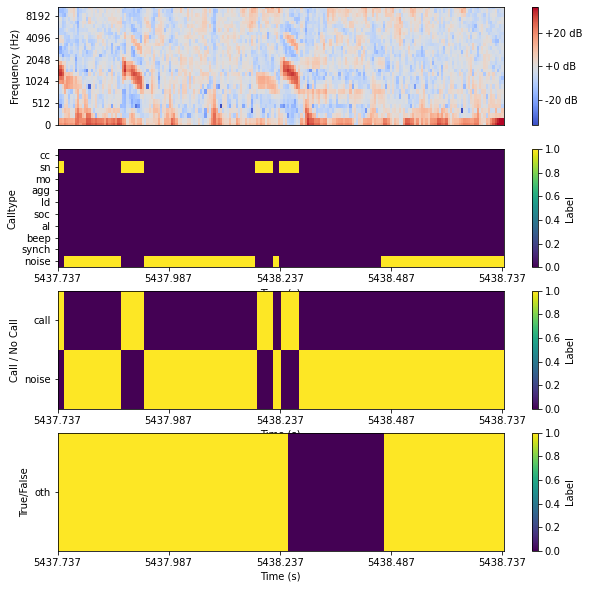

In [17]:
# set the labels
label_list = list(call_types.keys())
if other_ignored_in_training:
    label_list.remove(label_for_other)

if is_forked == True:
    # plot spectrogram
    plt.figure(figsize=(10, 10))
    plt.subplot(411)
    yaxis = range(0, np.flipud(spec).shape[0]+1)
    xaxis = range(0, np.flipud(spec).shape[1]+1)
    librosa.display.specshow(spec,  y_axis='mel', x_coords = label.columns)#, x_axis= "time",sr=sr, x_coords = label.columns)
    plt.ylabel('Frequency (Hz)')
    plt.clim(-35, 35)
    plt.colorbar(format='%+2.0f dB')
    
    # plot LABEL
    plt.subplot(412)
    xaxis = range(0, np.flipud(label).shape[1]+1)
    yaxis = range(0, np.flipud(label).shape[0]+1)
    plt.yticks(np.arange(0.5, len(label_list)+0.5 ,1 ),reversed(label_list))
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    plt.pcolormesh(xaxis, yaxis, np.flipud(label))
    plt.xlabel('Time (s)')
    plt.ylabel('Calltype')
    plt.colorbar(label="Label")
    
    
    # plot call matrix
    plt.subplot(413)
    xaxis = range(0, np.flipud(label).shape[1]+1)
    yaxis = range(0, np.flipud(callmat).shape[0]+1)
    plt.yticks(np.arange(0.5, callmat.shape[0]+0.5 ,1 ), reversed(callmat.index.values))
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    plt.pcolormesh(xaxis, yaxis, np.flipud(callmat))
    plt.xlabel('Time (s)')
    plt.ylabel('Call / No Call')
    plt.colorbar(label="Label")
    # 
    
    plt.subplot(414)
    # plot the mask
    if mask_vector == True:
        test = np.asarray([int(x == True) for x in mask])
        # test = np.hstack(test)
        test = test[np.newaxis, ...]
        # plt.imshow(mask, aspect='auto', cmap=plt.cm.gray)
        xaxis = range(0, np.flipud(label).shape[1]+1)
        yaxis = range(0, np.flipud(test).shape[0]+1)
        # yaxis = range(0, 1)
        # plt.yticks(np.arange(0.5, 1 ,1 ), "oth")
        plt.yticks(np.arange(0.5, test.shape[0]+0.5 ,1 ), reversed(["oth"]))
        plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(test))
        plt.xlabel('Time (s)')
        plt.ylabel('True/False')
        plt.colorbar(label="Label")
        plt.clim(0, 1)
        plt.show()
    else:
    
        xaxis = range(0, np.flipud(mask).shape[1]+1)
        yaxis = range(0, np.flipud(mask).shape[0]+1)
        # plt.yticks(np.arange(0.5, np.flipud(mask).shape[0]+0.5 ,1 ),reversed(label_list))
        plt.xticks(np.arange(0, np.flipud(mask).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(mask).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(mask))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectrogram Channels')
        plt.colorbar(label="Other or not")
        plt.show()
else:
    # plot spectrogram
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    yaxis = range(0, np.flipud(spec).shape[0]+1)
    xaxis = range(0, np.flipud(spec).shape[1]+1)
    librosa.display.specshow(spec,  y_axis='mel', x_coords = label.columns)#, x_axis= "time",sr=sr, x_coords = label.columns)
    plt.ylabel('Frequency (Hz)')
    plt.clim(-35, 35)
    plt.colorbar(format='%+2.0f dB')
    
    # plot LABEL
    plt.subplot(312)
    xaxis = range(0, np.flipud(label).shape[1]+1)
    yaxis = range(0, np.flipud(label).shape[0]+1)
    plt.yticks(np.arange(0.5, len(label_list)+0.5 ,1 ),reversed(label_list))
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    plt.pcolormesh(xaxis, yaxis, np.flipud(label))
    plt.xlabel('Time (s)')
    plt.ylabel('Calltype')
    plt.colorbar(label="Label")
    
    
    plt.subplot(313)
    # plot the mask
    if mask_vector == True:
        test = np.asarray([int(x == True) for x in mask])
        # test = np.hstack(test)
        test = test[np.newaxis, ...]
        # plt.imshow(mask, aspect='auto', cmap=plt.cm.gray)
        xaxis = range(0, np.flipud(label).shape[1]+1)
        yaxis = range(0, np.flipud(test).shape[0]+1)
        # yaxis = range(0, 1)
        # plt.yticks(np.arange(0.5, 1 ,1 ), "oth")
        plt.yticks(np.arange(0.5, test.shape[0]+0.5 ,1 ), reversed(["oth"]))
        plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(test))
        plt.xlabel('Time (s)')
        plt.ylabel('True/False')
        plt.colorbar(label="Label")
        plt.clim(0, 1)
        plt.show()
    else:
        xaxis = range(0, np.flipud(mask).shape[1]+1)
        yaxis = range(0, np.flipud(mask).shape[0]+1)
        # plt.yticks(np.arange(0.5, np.flipud(mask).shape[0]+0.5 ,1 ),reversed(label_list))
        plt.xticks(np.arange(0, np.flipud(mask).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(mask).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(mask))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectrogram Channels')
        plt.colorbar(label="Other or not")
        plt.show()



-----------------------------------------
# TRAINING 

## Build the training and validation data generators (for real this time)

In [18]:
if is_forked == True:
    # get a batch to estimate rnn parameters
    x_train, y_train = train_generator.__next__()#__getitem__(0)
    
    # initial parameters
    num_calltypes = y_train[0].shape[2]
    gru_units = y_train[0].shape[1] 


    # initialise the training data generator and validation data generator
    train_generator = bg.ForkedDataGenerator(training_label_dict,
                                             training_label_table, 
                                             spec_window_size,
                                             n_mels, 
                                             window, 
                                             fft_win , 
                                             fft_hop , 
                                             normalise,
                                             label_for_noise,
                                             label_for_other,
                                             min_scaling_factor,
                                             max_scaling_factor,
                                             n_per_call,
                                             other_ignored_in_training,
                                             mask_value,
                                             mask_vector)
    
    val_generator = bg.ForkedDataGenerator(validation_label_dict,
                                           validation_label_table, 
                                           spec_window_size,
                                           n_mels, 
                                           window, 
                                           fft_win , 
                                           fft_hop , 
                                           normalise,
                                           label_for_noise,
                                           label_for_other,
                                           min_scaling_factor,
                                           max_scaling_factor,
                                           n_per_call,
                                           other_ignored_in_training,
                                           mask_value,
                                           mask_vector)
    
else:
    x_train, y_train = train_generator.__next__()#__getitem__(0)
    
    # initial parameters
    num_calltypes = y_train[0].shape[2]
    gru_units = y_train[0].shape[1] 
    
    train_generator = bg.DataGenerator(training_label_dict,
                                             training_label_table, 
                                             spec_window_size,
                                             n_mels, 
                                             window, 
                                             fft_win , 
                                             fft_hop , 
                                             normalise,
                                             label_for_noise,
                                             label_for_other,
                                             min_scaling_factor,
                                             max_scaling_factor,
                                             n_per_call,
                                             other_ignored_in_training,
                                             mask_value,
                                             mask_vector)
    
    val_generator = bg.DataGenerator(validation_label_dict,
                                           validation_label_table, 
                                           spec_window_size,
                                           n_mels, 
                                           window, 
                                           fft_win , 
                                           fft_hop , 
                                           normalise,
                                           label_for_noise,
                                           label_for_other,
                                           min_scaling_factor,
                                           max_scaling_factor,
                                           n_per_call,
                                           other_ignored_in_training,
                                           mask_value,
                                           mask_vector)    




## Construct the RNN

In [19]:
# initialise the model class
model = rnn.BuildNetwork(x_train, num_calltypes, filters, gru_units, dense_neurons, dropout, mask_value)

# build the model
if is_forked == True:
    RNN_model = model.build_forked_masked_rnn()
else:
    RNN_model = model.build_masked_rnn()
    
# Adam optimiser
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
RNN_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

# Setup callbycks: learning rate / loss /tensorboard
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1,
                                   mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
loss = LossHistory()

# setup a path with a timestamp
date_time = datetime.datetime.now()
date_now = str(date_time.date())
time_now = str(date_time.time())
save_tensorboard_path = os.path.join(save_model_path, "tensorboard_logs_" + date_now + "_" + time_now)
if not os.path.isdir(save_tensorboard_path):
    os.makedirs(save_tensorboard_path)   

# tensorboard
tensorboard = TensorBoard(log_dir = save_tensorboard_path,
                          histogram_freq=0,
                          write_graph=True,  # Show the network
                          write_grads=True   # Show gradients
                          )  
# fit model
RNN_model.fit_generator(train_generator, 
                        steps_per_epoch = train_generator.__len__(),
                        epochs = epochs,
                        callbacks = [early_stopping, reduce_lr_plat, loss, tensorboard],
                        validation_data = val_generator,
                        validation_steps = val_generator.__len__())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/200
153/153 [==============================] - 378s 2s/step - loss: 0.8333 - output_calltype_loss: 0.2386 - output_callpresence_loss: 0.5946 - output_calltype_binary_accuracy: 0.9301 - output_callpresence_binary_accuracy: 0.7179 - val_loss: 0.8902 - val_output_calltype_loss: 0.2083 - val_output_callpresence_loss: 0.6819 - val_output_calltype_binary_accuracy: 0.9488 - val_output_callpresence_binary_accuracy: 0.7913

Epoch 2/200
153/153 [==============================] - 268s 2s/step - loss: 0.6165 - output_calltype_loss: 0.1625 - output_callpresence_loss: 0.4540 - output_calltype_binary_accuracy: 0.9530 - output_callpresence_binary_accuracy: 0.8189 - val_loss: 0.7192 - val_output_calltype_loss: 0.1833 - val_output_callpresence_loss: 0.5358 - val_output_callty

## View the model

In [25]:
from keras.utils import plot_model
plot_model(RNN_model, run_name + ".png", show_shapes=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

## Save the model

In [20]:
# save the model
date_time = datetime.datetime.now()
date_now = str(date_time.date())
time_now = str(date_time.time())
sf = os.path.join(save_model_path, run_name+ "_" + date_now + "_" + time_now)
if not os.path.isdir(sf):
    os.makedirs(sf)

RNN_model.save(sf + '/savedmodel' + '.h5')

print(sf)

Layer bidirectional_1 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_2:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).


/media/kiran/D0-P1/animal_data/meerkat/EXAMPLE_NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked/trained_model/EXAMPLE_NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_2021-05-12_00:19:17.080719


-------------------------------------------
# TESTING

This is probably the longest part of the code. We are finding the test files and finding the start and end of the labelling in that file and generating a spectrogram and predicting call types and shifting the window 30s and generating the next spectrogram. Once these predictions are created, they are then thresholded, and these thresholds used to decide whether there is a call or not.

## Predict over the test files

In [21]:
file_ID = testing_filenames[0]
# subset the label table to only use that one file
label_table = testing_label_table[testing_label_table['wavFileName'].isin([file_ID])].reset_index()

# Find the file ID name i.e. remove the extention
file_ID = file_ID.split(".")[0] 

# find the matching audio for the label data
audio_path = label_table["wav_path"][0]  

In [39]:
skipped_files = []

# we only do one file in this example to avoid it running too long
for file_ID in testing_filenames:
    # file_ID = testing_filenames[0] # for testing purposes only
    
    # subset the label table to only use that one file
    label_table = testing_label_table[testing_label_table['wavFileName'].isin([file_ID])].reset_index()
    # Find the file ID name i.e. remove the extention
    file_ID = file_ID.split(".")[0] 
    # find the matching audio for the label data
    audio_path = label_table["wav_path"][0]   
    
    print("*****************************************************************")   
    print("*****************************************************************") 
    print ("File being processed : " + audio_path)    
    
    # find the start and stop  of the labelling periods (also using skipon/skipoff)
    loop_table = label_table.loc[label_table["Label"].str.contains('|'.join(label_for_startstop), regex=True, case = False), ["Label","Start"]]
    loop_times = list(loop_table["Start"])
    
    # Make sure that the file contains the right number of start and stops, otherwise go to the next file
    if len(loop_times)%2 != 0:
        print("!!!!!!!!!!!!!!!!")
        warnings.warn("There is a missing start or stop in this file and it has been skipped: " + audio_path)
        skipped_files.append(file_ID)
        continue 
    
    if len(loop_times) == 0:
        print("!!!!!!!!!!!!!!!!")
        warnings.warn("There is a missing start or stop in this file and it has been skipped: " + audio_path)
        skipped_files.append(file_ID)
        continue 
    
    # save the label_table
    save_label_table_filename = file_ID + "_LABEL_TABLE.txt"
    label_table.to_csv(os.path.join(save_label_table_test_path, save_label_table_filename), 
                        header=True, index=None, sep=';')
    
    # load the audio data
    y, sr = librosa.load(audio_path, sr=None, mono=False)
    
    # # Reshaping the Audio file (mono) to deal with all wav files similarly
    # if y.ndim == 1:
    #     y = y.reshape(1, -1)
    
    # # Implement this for acc data
    # for ch in range(y.shape[0]):
    # ch=0
    # y_sub = y[:,ch]
    y_sub = y
    
    # loop through every labelling start based on skipon/off within this loop_table
    for loopi in range(0, int(len(loop_times)), 2):
        # loopi = 0
        fromi =  loop_times[loopi]
        #toi = fromi + 5
        toi = loop_times[int(loopi + 1)] # define the end of the labelling periods
        
        # if the file exists, load it
        if os.path.exists(os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy')): 
            calltype_pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy')) 
            callpresence_pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'))
       
        # if not, generate it
        else:
        
            calltype_pred_list = []
            callpresence_pred_list = []
    
            for spectro_slide in np.arange(fromi, toi, slide):
                
                # spectro_slide = fromi
                start = round(spectro_slide,3)
                stop = round(spectro_slide + spec_window_size, 3)
                
                # ignore cases where the window is larger than what is labelled (e.g. at the end)
                if stop <= toi:
                    
                    #generate the spectrogram
                    spectro = pre.generate_mel_spectrogram(y=y_sub, sr=sr, start=start, stop=stop, 
                                                            n_mels = n_mels, window='hann', 
                                                            fft_win= fft_win, fft_hop = fft_hop, 
                                                            normalise = True)
                    
                    # transpose it and put it in a format that works with the NN
                    spec = spectro.T
                    spec = spec[np.newaxis, ..., np.newaxis]  
                    
                    # generate a mask (as a placeholder) but don't mask anything as we are predicting and want to include other
                    mask = np.asarray([True for i in range(spectro.shape[1])])
                    mask = mask[np.newaxis,...]
                    
                    # generate the prediction
                    pred = RNN_model.predict([spec,mask])
                                       
                    # add this prediction to the stack that will be used to generate the predictions table
                    if is_forked:
                        calltype_pred_list.append(np.squeeze(pred[0]))
                        callpresence_pred_list.append(np.squeeze(pred[1]))
                    else:
                        calltype_pred_list.append(np.squeeze(pred))
                    
            # save the prediction stacks
            np.save( os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'), calltype_pred_list)
            with open(os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.txt'), "w") as f:
                for row in calltype_pred_list:
                    f.write(str(row) +"\n")
            if is_forked:      
                np.save( os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'), callpresence_pred_list)
                with open(os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.txt'), "w") as f:
                    for row in callpresence_pred_list:
                        f.write(str(row) +"\n")
                
        # Loop through different sets of thresholds
        for low_thr in [0.1,0.2, 0.3]:
            for high_thr in [0.3,0.4,0.5,0.6,0.5,0.7,0.8,0.9,0.95]: 
                
                # make sure it doesnt generate a 0.00098982374957839486 type number
                low_thr = round(low_thr,2)                               
                high_thr = round(high_thr,2)
                
                # stop the loop if the low threshold is bigger than the high threshold
                if low_thr >= high_thr:
                    continue

                save_pred_table_filename = file_ID + "_CALLTYPE_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + ".txt"
                
                # if the file exists, pass to the next iteration of the loop
                #if os.path.exists(os.path.join(save_pred_table_test_path, save_pred_table_filename)):
                #    continue
                
                print("*****************************************************************") 
                print ("Low Threshold: " + str(low_thr))    
                print ("High Threshold: " + str(high_thr))  
                
                #----------------------------------------------------------------------------
                # Compile the predictions for each on/off labelling chunk
                detections = ppm.merge_p(probabilities = calltype_pred_list, 
                                          labels=list(call_types.keys()),
                                          starttime = 0, 
                                          frameadv_s = fft_hop, 
                                          specadv_s = slide,
                                          low_thr=low_thr, 
                                          high_thr=high_thr, 
                                          debug=1)
                
                #in case the dataset was just noise, still create an empty placeholder to merge
                if len(detections) == 0:  
                    detections = pd.DataFrame(columns = ['category', 'start', 'end', 'scores'])
                
                # create an empty dataset
                pred_table = pd.DataFrame() 
                
                #convert these detections to a predictions table                
                table = pd.DataFrame(detections)
                table["Label"] = table["category"]
                table["Start"] = round(table["start"]*fft_hop + fromi, 3) #table["start"].apply(Decimal)*Decimal(fft_hop) + Decimal(fromi)
                table["Duration"] = round( (table["end"]-table["start"])*fft_hop, 3) #(table["end"].apply(Decimal)-table["start"].apply(Decimal))*Decimal(fft_hop)
                table["End"] = round(table["end"]*fft_hop + fromi, 3) #table["Start"].apply(Decimal) + table["Duration"].apply(Decimal)
                
                # keep only the useful columns    
                table = table[["Label","Start","Duration", "End", "scores"]]  
                
                # Add a row which stores the start of the labelling period
                row_start = pd.DataFrame()
                row_start.loc[0,'Label'] = list(loop_table["Label"])[loopi]
                row_start.loc[0,'Start'] = fromi
                row_start.loc[0,'Duration'] = 0
                row_start.loc[0,'End'] = fromi 
                row_start.loc[0,'scores'] = None
                
                # Add a row which stores the end of the labelling period
                row_stop = pd.DataFrame()
                row_stop.loc[0,'Label'] = list(loop_table["Label"])[int(loopi + 1)]
                row_stop.loc[0,'Start'] = toi
                row_stop.loc[0,'Duration'] = 0
                row_stop.loc[0,'End'] = toi 
                row_start.loc[0,'scores'] = None
                
                # put these rows to the label table
                table = pd.concat([row_start, table, row_stop]) 
                
                # add the true false columns based on the call types dictionary
                for true_label in call_types:
                    table[true_label] = False
                    for old_label in call_types[true_label]:
                        table.loc[table["Label"].str.contains(old_label, regex=True, case = False), true_label] = True
                
                # add this table to the overall predictions table for that collar
                pred_table = pd.concat([pred_table, table ])
                
                # for each on/off labelling chunk, we can save the prediction and append it to the previous chunk
                if loopi == 0:                    
                    # for the first chunck keep the header, but not when appending later
                    pred_table.to_csv(os.path.join(save_pred_table_test_path, save_pred_table_filename), 
                                      header=True, index=None, sep=';', mode = 'a')
                else:
                    pred_table.to_csv(os.path.join(save_pred_table_test_path, save_pred_table_filename), 
                                      header=None, index=None, sep=';', mode = 'a')
 
'''
# # load the saved file
# with open(os.path.join(save_pred_stack_test_path, file_ID + '_PRED_STACK.txt')) as f:
#     content = f.readlines()
# # remove whitespace characters like `\n` at the end of each line
# pred_list = [x.strip() for x in content] 


# #or
# pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_PRED_STACK.npy'))
# '''
        
# save the files that were skipped
print(skipped_files)

# save a copy of the training and testing diles
with open(os.path.join(save_model_path, "skipped_testing_files.txt"), "w") as f:
    for s in skipped_files:
        f.write(str(s) +"\n")
       
##############################################################################################
# Loop through tables and remove duplicates of rows (bevause files are created through appending)

pred_tables = glob.glob(save_pred_table_test_path + "/*CALLTYPE_PRED_TABLE*.txt")
for file in pred_tables:
    df = pd.read_csv(file, delimiter=';') 
    # df = df.drop_duplicates(keep=False)
    df = df.loc[df['Label'] != 'Label']
    df.to_csv(file, header=True, index=None, sep=';', mode = 'w')
     

*****************************************************************
*****************************************************************
File being processed : /home/kiran/Documents/MPI-Server/EAS_shared/meerkat/archive/rawdata/MEERKAT_RAW_DATA/2019/HM_2019_2/COLLAR/AUDIO/HM_VHMM021_MBLT_R01_20190707-20190719/HM_VHMM021_MBLT_R01_20190707-20190719_file_12_(2019_07_18-11_44_59)_185944.wav
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.3
Detecting calls in probability streams:  0 / 1021
Detecting calls in probability streams:  1000 / 1021
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.4
Detecting calls in probability streams:  0 / 1021
Detecting calls in probability streams:  1000 / 1021
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 1021
Detecting calls in probability streams:  100

# Evaluate

In [78]:
import importlib
importlib.reload(metrics)

<module 'postprocess.evaluation_metrics_functions' from '/home/kiran/Documents/github/CCAS_ML/postprocess/evaluation_metrics_functions.py'>

In [79]:
no_call = set(["noise", "beep", "synch"])
true_call= set(set(call_types.keys()).difference(no_call))
file_ID_list = [file_ID.split(".")[0] for file_ID in testing_filenames if file_ID not in skipped_files]
label_list =  [os.path.join(save_label_table_test_path,file_ID.split(".")[0]  + "_LABEL_TABLE.txt" ) for file_ID in file_ID_list]

# will go in params
eval_analysis = "normal"#"call_type_by_call_type"
#true_call= set(list(call_types.keys()).difference(no_call))
save_metrics_path_eval = os.path.join(save_metrics_path, eval_analysis)
if not os.path.isdir(save_metrics_path_eval):
    os.makedirs(save_metrics_path_eval)


# because of new file format, need to only keep certain columns
column_names = ["Label","Start","Duration","End"]
column_names.extend(list(testing_label_dict.keys()))
for file in label_list :
    df = pd.read_csv(file, delimiter=';') 
    # df = df.drop_duplicates(keep=False)
    df = df[column_names]
    df.to_csv(file, header=True, index=None, sep=';', mode = 'w')


for low_thr in [0.1,0.2,0.3]:
    for high_thr in [0.3,0.4,0.5,0.6,0.5,0.7,0.8,0.9,0.95]: 
        
        low_thr = round(low_thr,2)                               
        high_thr = round(high_thr,2) 
        
        if low_thr >= high_thr:
            continue
        
        pred_list = [os.path.join(save_pred_table_test_path,file_ID.split(".")[0]  + "_CALLTYPE_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + ".txt" ) for file_ID in file_ID_list ]
        evaluation = metrics.Evaluate(label_list = label_list, 
                                      prediction_list = pred_list, 
                                      noise_label = "noise", 
                                      IoU_threshold = 0.5, 
                                      call_analysis = eval_analysis, 
                                      GT_proportion_cut = 0, 
                                      no_call = no_call) # 0.99 is 0.5
        output = evaluation.main()        
        
        
        # specify file names
        precision_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Precision.csv'
        recall_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Recall.csv'
        cat_frag_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Category_fragmentation.csv'
        time_frag_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Time_fragmentation.csv'
        confusion_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Confusion_matrix.csv'
        gt_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Label_indices.p"
        pred_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Prediction_indices.p"
        match_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Matching_table.txt"
        timediff_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Time_difference.txt"    
        
        # NEW METRICS
        lenient_Prec_filename  = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Lenient_Precision.csv'
        lenient_Rec_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Lenient_Recall.csv'
        call_match_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Call_Match.p"
        pred_match_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Prediction_Match.p"
        match2_filename = "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_Match.csv"
        
        # save files
        output["Precision"].to_csv( os.path.join(save_metrics_path_eval, precision_filename))
        output["Recall"].to_csv( os.path.join(save_metrics_path_eval, recall_filename))
        output["Category_Fragmentation"].to_csv( os.path.join(save_metrics_path_eval, cat_frag_filename))
        output["Time_Fragmentation"].to_csv(os.path.join(save_metrics_path_eval, time_frag_filename))
        output["Confution_Matrix"].to_csv(os.path.join(save_metrics_path_eval, confusion_filename))
        with open(os.path.join(save_metrics_path_eval, gt_filename), 'wb') as fp:
            pickle.dump(output["Label_Indices"], fp)
        with open(os.path.join(save_metrics_path_eval, pred_filename), 'wb') as fp:
            pickle.dump(output["Prediction_Indices"], fp)
        with open(os.path.join(save_metrics_path_eval, match_filename), "wb") as fp:   #Picklin
            pickle.dump(output["Matching_Table"], fp)
        with open(os.path.join(save_metrics_path_eval, timediff_filename), "wb") as fp:   #Pickling
            pickle.dump( output["Time_Difference"], fp)
        
        #save new metrics
        output["Lenient_Precision"].to_csv(os.path.join(save_metrics_path_eval, lenient_Prec_filename))        
        output["Lenient_Recall"].to_csv(os.path.join(save_metrics_path_eval, lenient_Rec_filename))
        if eval_analysis == "call_type_by_call_type":
            with open(os.path.join(save_metrics_path_eval, call_match_filename), 'wb') as fp:
                pickle.dump(output["Call_Match"], fp)  
            with open(os.path.join(save_metrics_path_eval, pred_match_filename), 'wb') as fp:
                pickle.dump(output["Prediction_Match"], fp)  
        if eval_analysis in true_call:
            with open(os.path.join(save_metrics_path_eval, match2_filename), 'wb') as fp:
                pickle.dump(output["Match"], fp)  

Evaluating nonfoc calls...
Matching predictions ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Finding true positives:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Finding false negatives:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Marking False positives
0 oth : False
0 synch : False
0 beep : False
0 sn : False
0 mo : False
0 cc : False
0 al : False
0 agg : False
0 noise : False
0 ld : False
0 soc : False
1 oth : False
1 synch : False
1 beep : False
1 sn : False
1 mo : False
1 cc : False
1 al : False
1 agg : False
1 noise : False
1 ld : False
1 soc : False
2 oth : False
2 synch : False
2 beep : False
2 sn : False
2 mo : False
2 cc : False
2 al : False
2 agg : False
2 noise : False
2 ld : False
2 soc : False
3 oth : False
3 synch : False
3 beep : False
3 sn : False
3 mo : False
3 cc : False
3 al : False
3 agg : False
3 noise : False
3 ld : False
3 soc : False
4 oth : False
4 syn

KeyError: 'noise'

# Plot the confusion matrix

In [ ]:
# loop over the threaholds
for low_thr in [0.1,0.2,0.3]:
    for high_thr in [0.3,0.4,0.5,0.6,0.5,0.7,0.8,0.9,0.95]: 
        
        low_thr = round(low_thr,2)                               
        high_thr = round(high_thr,2) 
        
        if low_thr >= high_thr:
            continue

        confusion_filename = os.path.join(save_metrics_path_eval, "Overall_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_Confusion_matrix.csv')
        with open(confusion_filename, newline='') as csvfile:
            array = list(csv.reader(csvfile))
    
        df_cm = pd.DataFrame(array)#, range(6), range(6))    
        
        # get rid of the weird indentations and make rows and columns as names
        new_col = df_cm.iloc[0] # grab the first row for the header
        df_cm = df_cm[1:] # take the data less the header row
        df_cm.columns = new_col # set the header row as the df header    
        new_row = df_cm['']
        df_cm = df_cm.drop('', 1)
        df_cm.index = new_row
        df_cm.index.name= None
        df_cm.columns.name= None
        
        # # replace FP and FN with noise
        df_cm['noise'] = df_cm['FN'] 
        #df_cm.loc['noise']=df_cm.loc['FP']
        
        # remove FP and FN
        df_cm = df_cm.drop("FN", axis=1)
        #df_cm = df_cm.drop("FP", axis=0)
        
        df_cm = df_cm.apply(pd.to_numeric)
                
        # Raw confusion matrix
        df_cm = df_cm[list(testing_label_dict.keys())]
        df_cm = df_cm.reindex(list(testing_label_dict.keys()))
        
        
        # plot raw
        plt.subplot(3,1,1)
        ax = plt.axes()
        sn.set(font_scale=1.1) # for label size
        sn.heatmap((df_cm+1), annot=df_cm, fmt='g',norm = LogNorm(), annot_kws={"size": 10}, ax= ax) # font size
        ax.set_title("Raw: "+str(low_thr) + "-" + str(high_thr) )
        #plt.savefig(os.path.join(save_metrics_path, "Confusion_mat_thr_" + str(low_thr) + "-" + str(high_thr) + '.png'))
        #plt.show()

        # Recall confusion matrix
        df_recall = df_cm.div(df_cm.sum(axis=1), axis=0).round(2)#pd.DataFrame(df_cm.values / df_cm.sum(axis=1).values).round(2)
        
        # plot recall
        plt.subplot(3,1,2)
        ax = plt.axes()
        sn.set(font_scale=1.1) # for label size
        sn.heatmap((df_recall), annot=True, fmt='g', annot_kws={"size": 10}, ax= ax) # font size
        ax.set_title("Recall: "+str(low_thr) + "-" + str(high_thr) )
        #plt.savefig(os.path.join(save_metrics_path, "Confusion_mat_recall_thr_" + str(low_thr) + "-" + str(high_thr) + '.png'))
        #plt.show()        
        
        # Proportion of calls for confusion matrix
        call_len = list()
        for i in testing_label_dict.keys():
            call_len.append(testing_label_dict[i].shape[0])
        # add noise at the end
        call_len[-1] = df_cm.sum(axis=1)[-1]
        
        # plot proportion of calls
        df_prop = df_cm.div(call_len, axis=0).round(2)#pd.DataFrame(df_cm.values / df_cm.sum(axis=1).values).round(2)
        plt.subplot(3,1,3)
        ax = plt.axes()
        sn.set(font_scale=1.1) # for label size
        sn.heatmap((df_prop), annot=True, fmt='g', annot_kws={"size": 10}, ax= ax) # font size
        ax.set_title("Call Prop: "+str(low_thr) + "-" + str(high_thr) )
        #plt.savefig(os.path.join(save_metrics_path, "Confusion_mat_prop_thr_" + str(low_thr) + "-" + str(high_thr) + '.png'))
        plt.savefig(os.path.join(save_metrics_path, "Confusion_mat_thr_" + str(low_thr) + "-" + str(high_thr) + '.png'))
        plt.show()